# 0. Install and Import dependencies

In [47]:
# Gym stuff
import os
import yfinance as yf
import itertools
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA
from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volatility import KeltnerChannel
from ta.trend import IchimokuIndicator

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import quantstats as qs

Define the constants for training the model

In [48]:
SEED = 5756

# Specify parameters
stock_name = 'AMD'

# Window size for training
train_window_size = 50
train_start = '2020-01-01'
train_end = '2023-06-01'

test_window_size = 50
learn_iteration = 100000

# Model parameters
model_name = 'PPO'

# Indicator parameters
sma_period = 10

# 1. Get Data

In [49]:
df = yf.Ticker(stock_name)
df = df.history(period="max")
df = df.loc[train_start:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(1163, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02 00:00:00-05:00,46.860001,49.250000,46.630001,49.099998,80331100
2020-01-03 00:00:00-05:00,48.029999,49.389999,47.540001,48.599998,73127400
2020-01-06 00:00:00-05:00,48.020000,48.860001,47.860001,48.389999,47934900
2020-01-07 00:00:00-05:00,49.349998,49.389999,48.040001,48.250000,58061400
2020-01-08 00:00:00-05:00,47.849998,48.299999,47.139999,47.830002,53767000


In [50]:
TRAIN_ENV_FRAME_BOUND = (train_window_size, df[train_start:train_end].shape[0])
TEST_ENV_FRAME_BOUND = (df[train_start:train_end].shape[0] + test_window_size, df.shape[0])

In [51]:
TRAIN_ENV_FRAME_BOUND

(50, 860)

In [52]:
TEST_ENV_FRAME_BOUND

(910, 1163)

# 2. Feature Engineering

## 2.1 Calculate SMA, RSI and OBV

In [53]:
df['SMA'] = TA.SMA(df, sma_period)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.2 Create New Environments

In [54]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [55]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train the Agent

In [56]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=train_window_size)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
from sb3_contrib import RecurrentPPO

if model_name == 'A2C':
    model = A2C('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'RecurrentPPO':
    model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=SEED)
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'PPO':
    model = PPO('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)
elif model_name == 'DQN':
    model = DQN('MlpPolicy', env, verbose=0, seed=SEED) 
    model.learn(total_timesteps=learn_iteration)

# 4. Evaluation

In [ ]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=test_window_size)
observation, info = env.reset()
while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 39.98002624511719, 'total_profit': 0.8798260593796677, 'position': <Positions.Short: 0>}


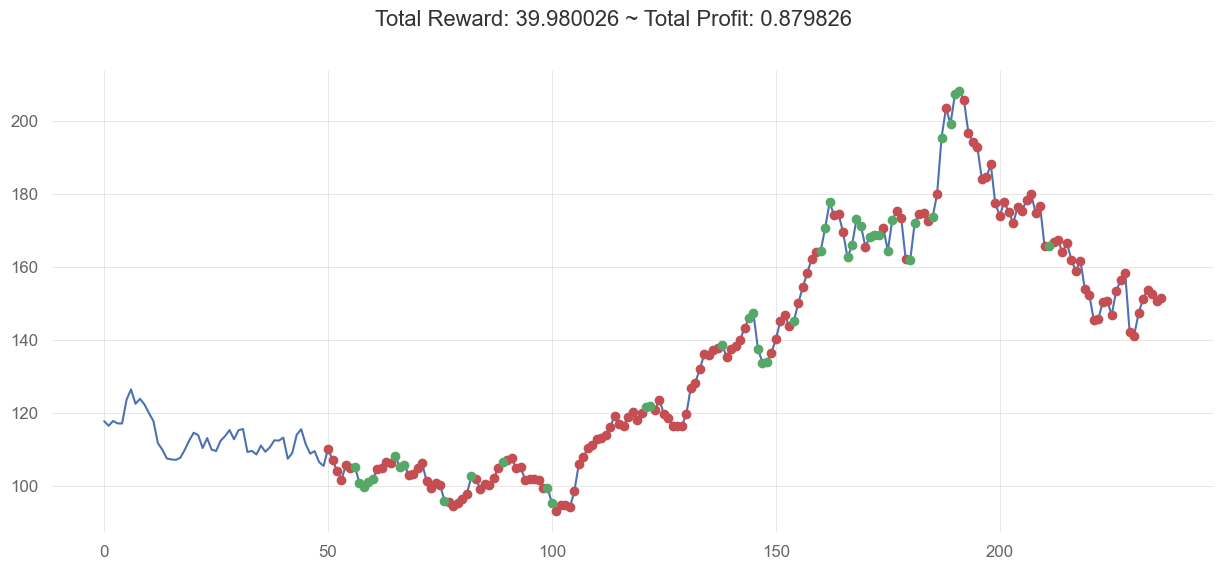

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats Analysis

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2023-08-17
End Period                 2024-05-10
Risk-Free Rate             0.0%
Time in Market             11.0%

Cumulative Return          -12.02%
CAGR﹪                     -11.38%

Sharpe                     -0.77
Prob. Sharpe Ratio         24.71%
Smart Sharpe               -0.76
Sortino                    -0.95
Smart Sortino              -0.95
Sortino/√2                 -0.67
Smart Sortino/√2           -0.67
Omega                      0.68

Max Drawdown               -30.06%
Longest DD Days            255
Volatility (ann.)          20.09%
Calmar                     -0.38
Skew                       -1.98
Kurtosis                   22.62

Expected Daily %           -0.07%
Expected Monthly %         -1.27%
Expected Yearly %          -6.2%
Kelly Criterion            -19.61%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.14%
Expected Shortfall (cVaR)  -2.14%

Max Consecut

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-08-30,2024-01-05,2024-05-10,255,-30.061472,-28.740939


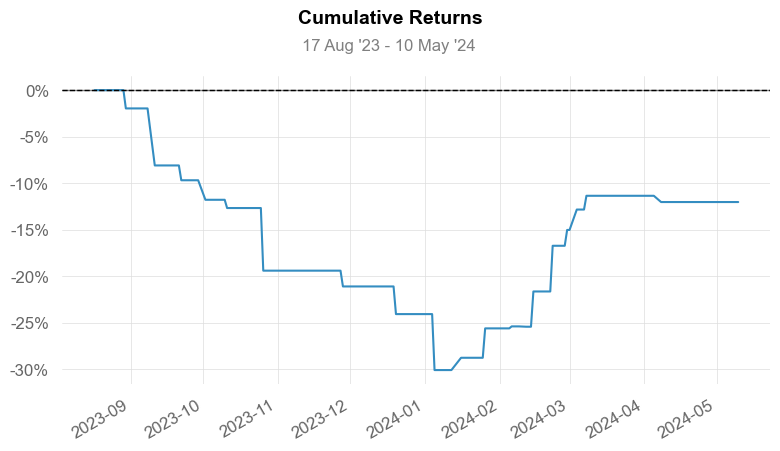

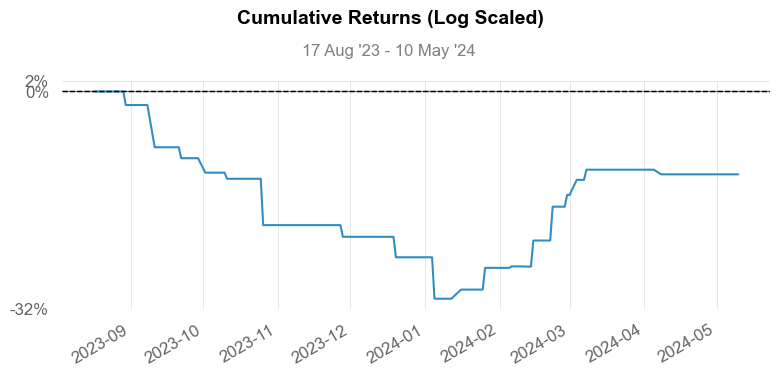

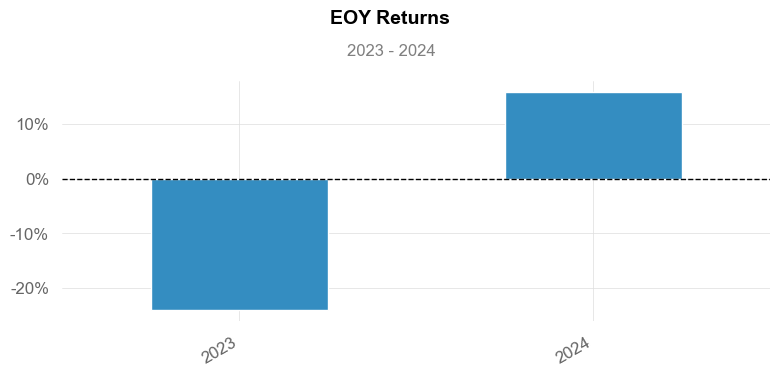

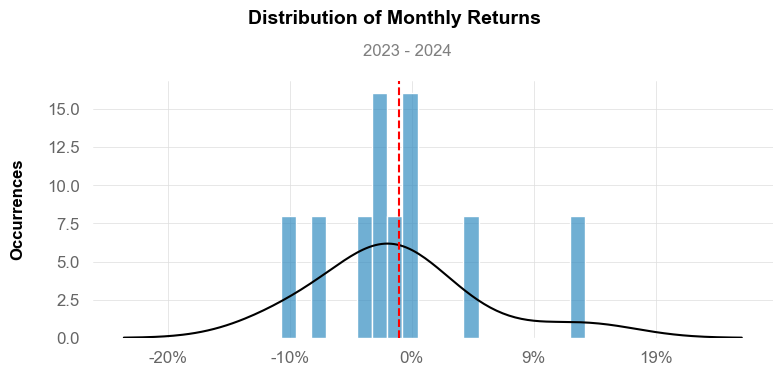

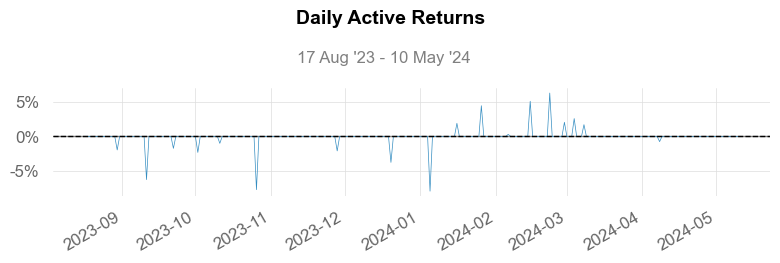

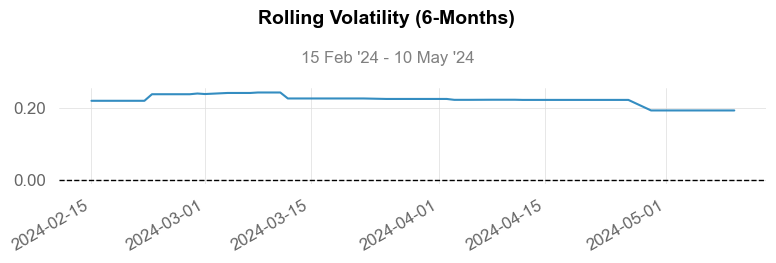

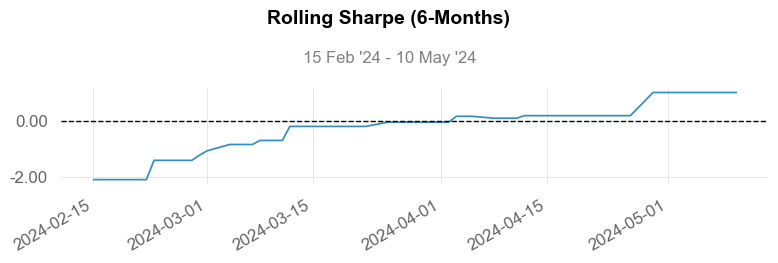

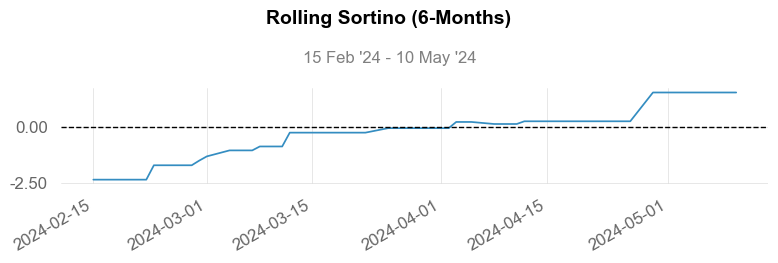

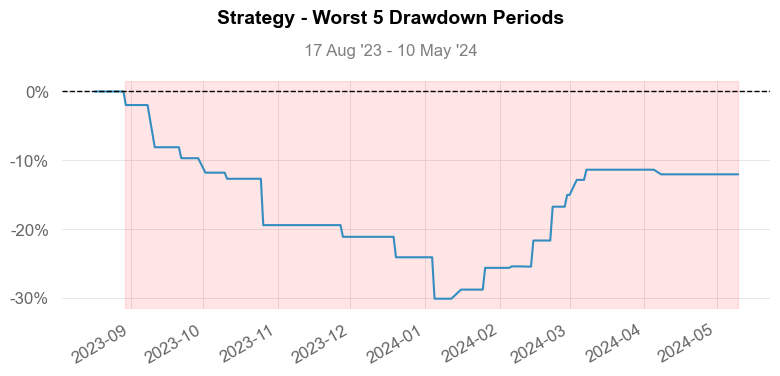

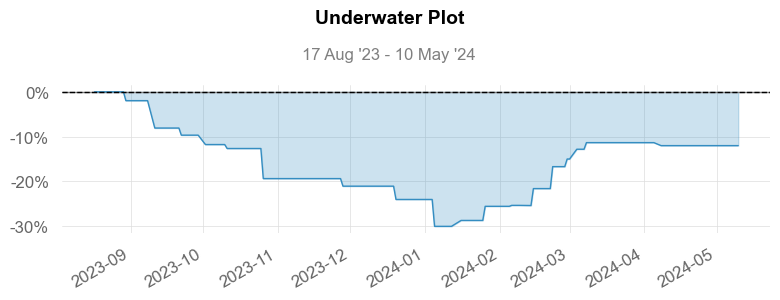

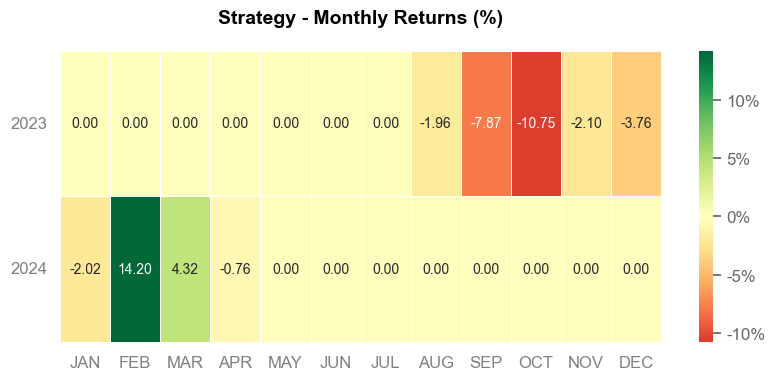

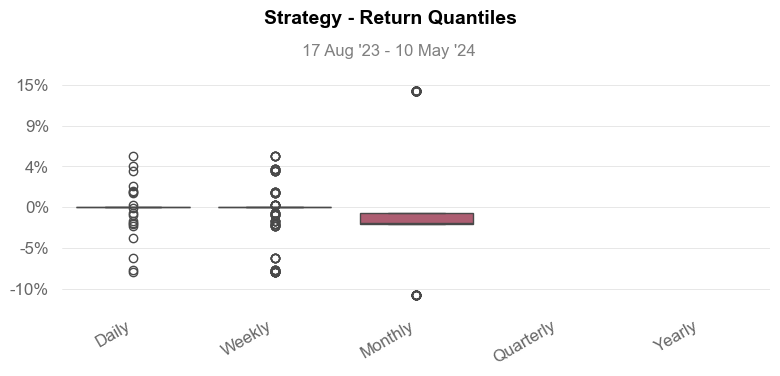

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)